#### imports

In [6]:
from qiskit import QuantumCircuit, assemble, Aer, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools import job_monitor
from qiskit_textbook.tools import array_to_latex
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from math import sqrt, pi

#### find out how many qubits are needed

In [7]:
# Ask for range (0 - x).
max_num = int(input('Choose x for a max range of  (0 - x)'))

# Find out how many qubits are needed based on range.
qubit_vals = [1]

while sum(qubit_vals) < max_num:
    qubit_vals.append(qubit_vals[-1] * 2)

if sum(qubit_vals) > max_num:
    qubit_vals.pop()

n_qubits = len(qubit_vals)

#### create quantum circuit

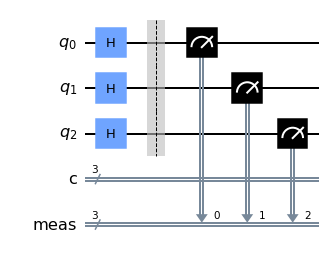

In [8]:
qc = QuantumCircuit(n_qubits, n_qubits)

for i in range(n_qubits):
    qc.h(i)

qc.measure_all()

qobj = assemble(qc)

qc.draw(output='mpl')

#### run on simulator

In [9]:
simulator = Aer.get_backend('statevector_simulator')

state = simulator.run(qobj).result().get_statevector()

array_to_latex(state, 'Number in bits = ')


<IPython.core.display.Math object>